# 1. IMPORTATIONS ET CONFIGURATION

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import torchvision.transforms.functional as F
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration

In [2]:
class Config:
    # Chemins des données
    data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")
    val_dir = os.path.join(data_dir, "val")
    
    # Hyperparamètres
    image_size = 224
    batch_size = 32
    num_epochs = 20
    learning_rate = 1e-4
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Seed pour la reproductibilité
    seed = 42
    
config = Config()
# Définition du seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

print(f"Device: {config.device}")

Device: cuda


# 2. EXPLORATION DES DONNÉES (EDA)

In [4]:
def explore_dataset():
    """Exploration complète du dataset"""
    
    # Analyse de la distribution des classes
    print("=" * 50)
    print("EXPLORATION DU DATASET")
    print("=" * 50)
    
    data_stats = {}
    
    for split in ['train', 'test', 'val']:
        split_dir = os.path.join(config.data_dir, split)
        if os.path.exists(split_dir):
            normal_count = len(os.listdir(os.path.join(split_dir, "NORMAL")))
            pneumonia_count = len(os.listdir(os.path.join(split_dir, "PNEUMONIA")))
            data_stats[split] = {
                'NORMAL': normal_count,
                'PNEUMONIA': pneumonia_count,
                'TOTAL': normal_count + pneumonia_count,
                'PNEUMONIA_RATIO': pneumonia_count / (normal_count + pneumonia_count)
            }
    
    # Création d'un DataFrame pour les statistiques
    stats_df = pd.DataFrame(data_stats).T
    print("\nDistribution des classes par split:")
    print(stats_df)
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution des classes
    splits = ['train', 'test', 'val']
    normal_counts = [data_stats[s]['NORMAL'] for s in splits]
    pneumonia_counts = [data_stats[s]['PNEUMONIA'] for s in splits]
    
    x = np.arange(len(splits))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, normal_counts, width, label='NORMAL', color='skyblue')
    axes[0, 0].bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA', color='salmon')
    axes[0, 0].set_xlabel('Split')
    axes[0, 0].set_ylabel('Nombre d\'images')
    axes[0, 0].set_title('Distribution des classes')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(splits)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Ratio de déséquilibre
    ratios = [data_stats[s]['PNEUMONIA_RATIO'] for s in splits]
    axes[0, 1].bar(splits, ratios, color=['green', 'blue', 'red'])
    axes[0, 1].set_ylabel('Ratio PNEUMONIA')
    axes[0, 1].set_title('Déséquilibre des classes')
    axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Analyse des tailles d'images
    print("\nAnalyse des dimensions d'images...")
    
    def get_image_sizes(folder_path, sample_size=50):
        sizes = []
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = os.path.join(folder_path, class_name)
            if os.path.exists(class_path):
                images = os.listdir(class_path)[:sample_size]
                for img_name in images:
                    img_path = os.path.join(class_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)
                    except:
                        continue
        return sizes
    
    train_sizes = get_image_sizes(config.train_dir)
    widths, heights = zip(*train_sizes)
    
    axes[1, 0].scatter(widths, heights, alpha=0.5)
    axes[1, 0].set_xlabel('Largeur (pixels)')
    axes[1, 0].set_ylabel('Hauteur (pixels)')
    axes[1, 0].set_title(f'Dimensions des images (échantillon: {len(train_sizes)})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Affichage d'exemples d'images
    axes[1, 1].axis('off')
    
    # Afficher quelques exemples
    fig_examples, axes_examples = plt.subplots(2, 4, figsize=(15, 8))
    
    for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        for j in range(4):
            ax = axes_examples[i, j]
            ax.axis('off')
            
            class_path = os.path.join(config.train_dir, class_name)
            if os.path.exists(class_path):
                images = os.listdir(class_path)
                if images:
                    img_path = os.path.join(class_path, images[j])
                    try:
                        img = Image.open(img_path).convert('RGB')
                        ax.imshow(img)
                        ax.set_title(f'{class_name}')
                    except:
                        ax.text(0.5, 0.5, 'Erreur', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df


EXPLORATION DU DATASET

Distribution des classes par split:
       NORMAL  PNEUMONIA   TOTAL  PNEUMONIA_RATIO
train  1341.0     3875.0  5216.0         0.742906
test    234.0      390.0   624.0         0.625000
val       8.0        8.0    16.0         0.500000

Analyse des dimensions d'images...


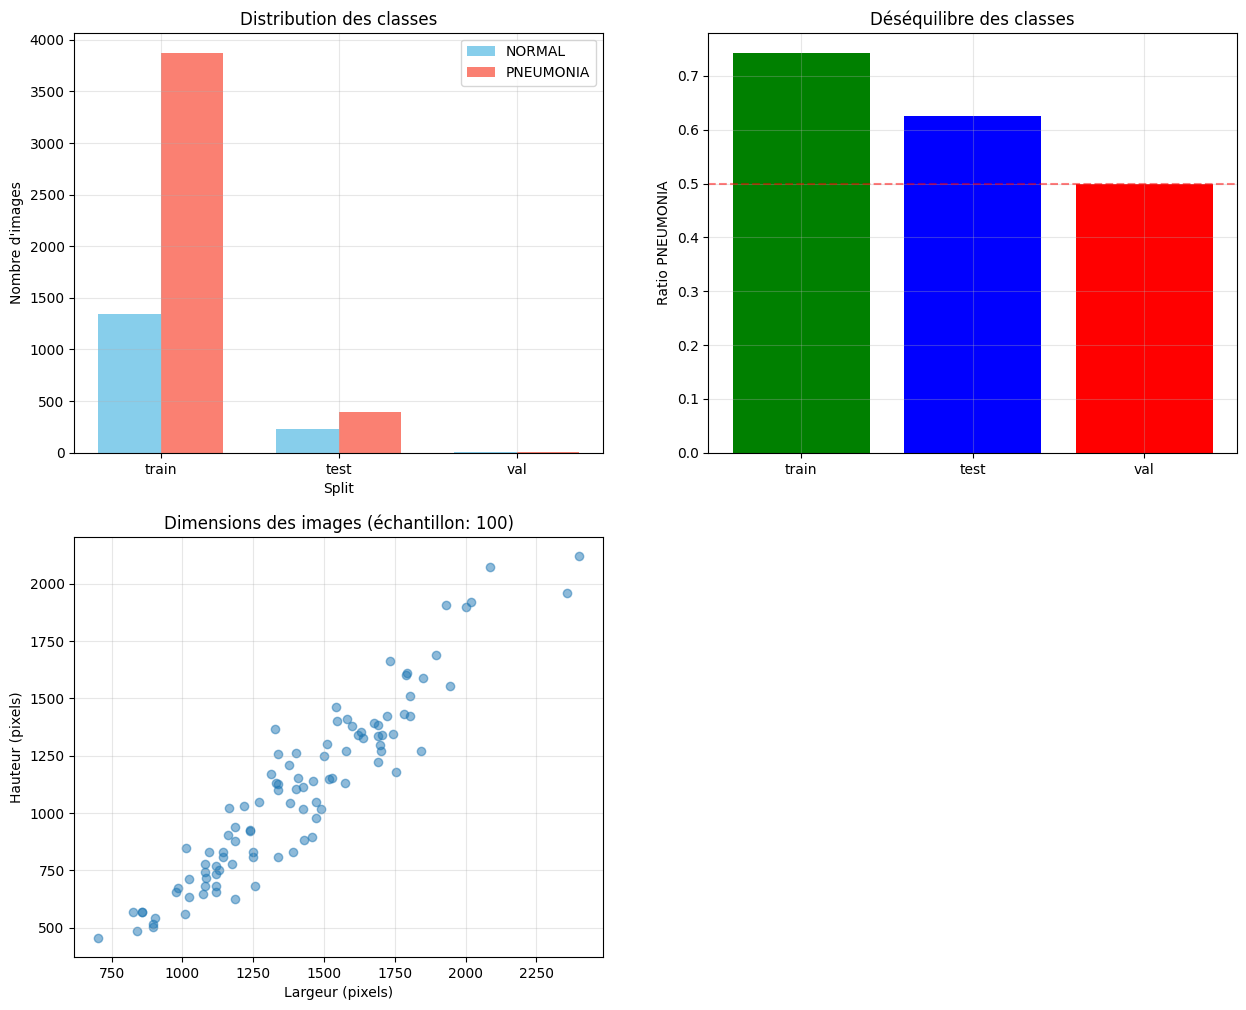

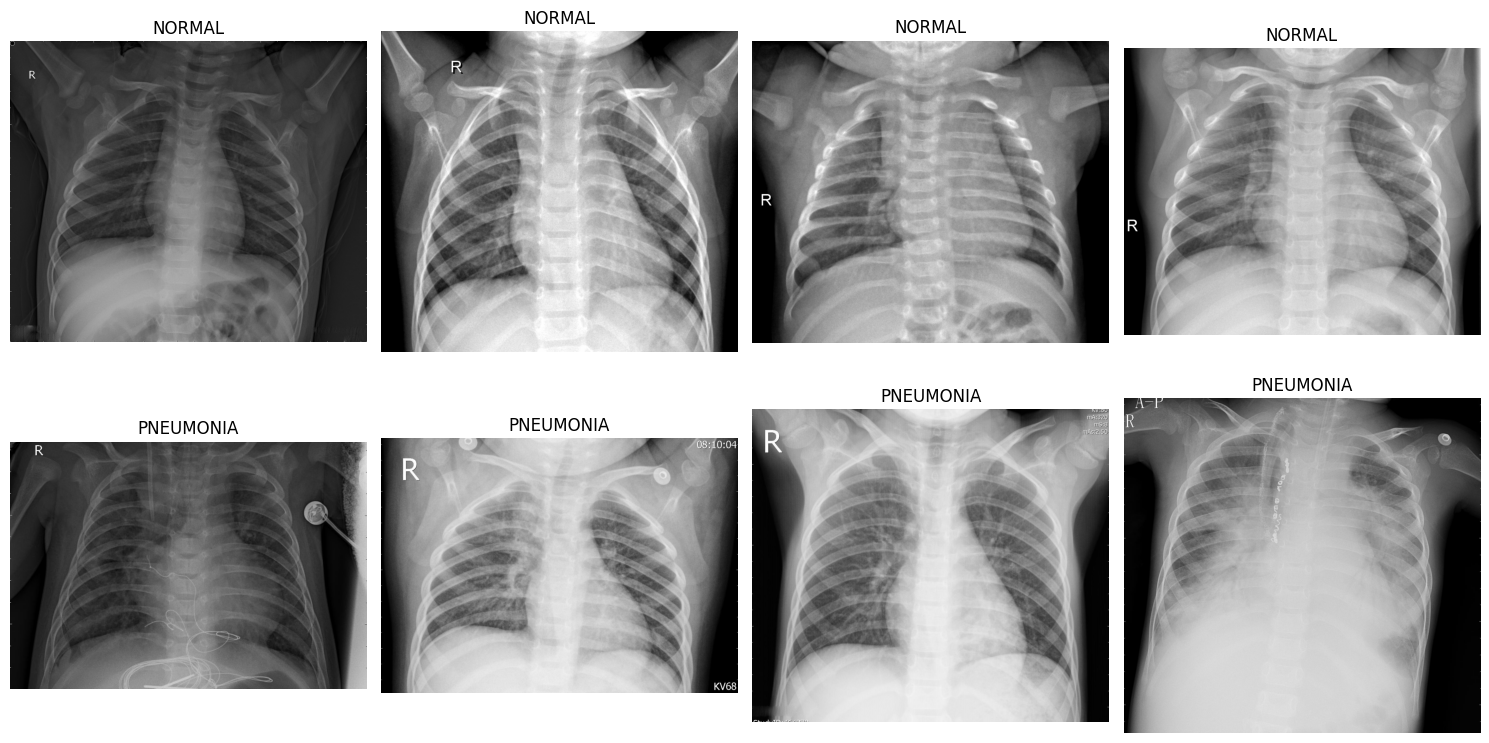

In [5]:
stats_df = explore_dataset()

# 3. DATASET ET DATALOADERS AVEC AUGMENTATION

In [6]:
class PneumoniaDataset(Dataset):
    """Dataset personnalisé pour les radiographies"""
    
    def __init__(self, root_dir, transform=None, phase='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.phase = phase
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Chargement des chemins d'images et labels
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Chargement de l'image
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Fallback si problème de chargement
            image = Image.new('RGB', (config.image_size, config.image_size), color='gray')
        
        # Application des transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_weights(self):
        """Calcule les poids pour chaque classe (pour gérer le déséquilibre)"""
        class_counts = [self.labels.count(0), self.labels.count(1)]
        total_samples = len(self.labels)
        
        # Poids inversement proportionnels à la fréquence
        weights = [total_samples / (len(self.classes) * count) for count in class_counts]
        return torch.FloatTensor(weights)


# Définition des transformations

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Création des datasets

In [8]:
train_dataset = PneumoniaDataset(config.train_dir, transform=train_transform, phase='train')
val_dataset = PneumoniaDataset(config.val_dir, transform=val_test_transform, phase='val')
test_dataset = PneumoniaDataset(config.test_dir, transform=val_test_transform, phase='test')

print(f"\nTaille des datasets:")
print(f"Train: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")


Taille des datasets:
Train: 5216 images
Validation: 16 images
Test: 624 images


# Calcul des poids de classe pour gérer le déséquilibre

In [9]:
class_weights = train_dataset.get_class_weights()
print(f"\nPoids des classes: {class_weights}")


Poids des classes: tensor([1.9448, 0.6730])


# Création d'un WeightedRandomSampler pour l'entraînement

In [10]:
train_labels = train_dataset.labels
class_counts = np.bincount(train_labels)
class_weights_sampler = 1. / class_counts
sample_weights = class_weights_sampler[train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Création des DataLoaders

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    sampler=sampler,
    num_workers=config.num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)


# 4. MODÈLES

# 4.1 CNN from scratch

In [13]:
class SimpleCNN(nn.Module):
    """CNN simple créé from scratch"""
    
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# 4.2 HRNet (Fine-tuning)

In [14]:
def create_hrnet_model(num_classes=2):
    """Crée un modèle HRNet pré-entraîné"""
    try:
        # Essayer d'importer HRNet
        from efficientnet_pytorch import EfficientNet
        
        # Utiliser EfficientNet-B4 comme alternative si HRNet n'est pas disponible
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=num_classes)
        print("Utilisation d'EfficientNet-B4 (alternative à HRNet)")
        return model
    except:
        # Fallback à ResNet50
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        print("Utilisation de ResNet50 (fallback)")
        return model


# 4.3 Vision Transformer (ViT)

In [16]:
def create_vit_model(num_classes=2):
    """Crée un modèle Vision Transformer"""
    try:
        from transformers import ViTForImageClassification, ViTConfig
        
        # Configuration ViT-Base
        config = ViTConfig.from_pretrained(
            'google/vit-base-patch16-224-in21k',
            num_labels=num_classes,
            finetuning_task='image-classification'
        )
        
        model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k',
            config=config,
            ignore_mismatched_sizes=True
        )
        
        print("Modèle ViT chargé avec succès")
        return model
    except Exception as e:
        print(f"Erreur lors du chargement de ViT: {e}")
        # Fallback à un CNN simple
        return SimpleCNN(num_classes)


# 5. FONCTIONS D'ENTRAÎNEMENT ET D'ÉVALUATION

In [17]:
class FocalLoss(nn.Module):
    """Focal Loss pour gérer le déséquilibre des classes"""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class Trainer:
    """Classe pour gérer l'entraînement et l'évaluation"""
    
    def __init__(self, model, model_name, device=config.device):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.scaler = GradScaler()  # Pour mixed precision training
        
        # Historique
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'train_f1': [], 'val_f1': [],
            'train_recall': [], 'val_recall': []
        }
    
    def train_epoch(self, train_loader, criterion, optimizer, scheduler=None):
        """Entraînement pour une époque"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Métriques additionnelles
        all_preds = []
        all_targets = []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            optimizer.zero_grad()
            
            # Mixed precision training
            with autocast():
                outputs = self.model(inputs)
                if hasattr(outputs, 'logits'):  # Pour les transformers
                    outputs = outputs.logits
                loss = criterion(outputs, targets)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()
            
            # Métriques
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        # Calcul des métriques additionnelles
        from sklearn.metrics import f1_score, recall_score
        epoch_f1 = f1_score(all_targets, all_preds, average='macro')
        epoch_recall = recall_score(all_targets, all_preds, average='macro')
        
        return epoch_loss, epoch_acc, epoch_f1, epoch_recall
    
    def validate(self, val_loader, criterion):
        """Validation"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_preds = []
        all_targets = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                
                outputs = self.model(inputs)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits
                
                loss = criterion(outputs, targets)
                running_loss += loss.item()
                
                probs = nn.functional.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        # Métriques additionnelles
        from sklearn.metrics import f1_score, recall_score
        epoch_f1 = f1_score(all_targets, all_preds, average='macro')
        epoch_recall = recall_score(all_targets, all_preds, average='macro')
        
        return epoch_loss, epoch_acc, epoch_f1, epoch_recall, all_probs, all_targets, all_preds
    
    def train(self, train_loader, val_loader, num_epochs=config.num_epochs):
        """Boucle d'entraînement complète"""
        
        # Définition de la loss et de l'optimizer
        criterion = FocalLoss(alpha=class_weights.to(self.device), gamma=2.0)
        optimizer = optim.AdamW(self.model.parameters(), lr=config.learning_rate, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        print(f"\n{'='*50}")
        print(f"Entraînement du modèle: {self.model_name}")
        print(f"{'='*50}")
        
        best_val_acc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 20)
            
            # Entraînement
            train_loss, train_acc, train_f1, train_recall = self.train_epoch(
                train_loader, criterion, optimizer, scheduler
            )
            
            # Validation
            val_loss, val_acc, val_f1, val_recall, _, _, _ = self.validate(val_loader, criterion)
            
            # Mise à jour du scheduler
            if scheduler:
                scheduler.step()
            
            # Sauvegarde de l'historique
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['train_f1'].append(train_f1)
            self.history['train_recall'].append(train_recall)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_f1'].append(val_f1)
            self.history['val_recall'].append(val_recall)
            
            # Affichage
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
            print(f"Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}")
            
            # Sauvegarde du meilleur modèle
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.model.state_dict().copy()
                torch.save(best_model_state, f'best_{self.model_name}.pth')
                print(f"Modèle sauvegardé (Accuracy: {val_acc:.2f}%)")
        
        # Chargement du meilleur modèle
        if best_model_state:
            self.model.load_state_dict(best_model_state)
        
        return self.history
    
    def evaluate(self, test_loader):
        """Évaluation finale sur le test set"""
        print(f"\n{'='*50}")
        print(f"Évaluation du modèle {self.model_name} sur le test set")
        print(f"{'='*50}")
        
        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc, test_f1, test_recall, probs, targets, preds = self.validate(test_loader, criterion)
        
        # Métriques détaillées
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
        
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.2f}%")
        print(f"Test F1-Score: {test_f1:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        
        # Rapport de classification
        print("\nClassification Report:")
        print(classification_report(targets, preds, target_names=['NORMAL', 'PNEUMONIA']))
        
        # Matrice de confusion
        cm = confusion_matrix(targets, preds)
        self.plot_confusion_matrix(cm, ['NORMAL', 'PNEUMONIA'])
        
        # Courbe ROC
        if len(np.unique(targets)) == 2:
            probs_array = np.array(probs)[:, 1]  # Probabilités pour la classe positive
            auc = roc_auc_score(targets, probs_array)
            print(f"\nAUC-ROC: {auc:.4f}")
            
            fpr, tpr, _ = roc_curve(targets, probs_array)
            self.plot_roc_curve(fpr, tpr, auc)
        
        return {
            'accuracy': test_acc,
            'f1_score': test_f1,
            'recall': test_recall,
            'loss': test_loss,
            'predictions': preds,
            'targets': targets,
            'probabilities': probs
        }
    
    def plot_confusion_matrix(self, cm, classes):
        """Visualisation de la matrice de confusion"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Matrice de confusion - {self.model_name}')
        plt.ylabel('Vraies étiquettes')
        plt.xlabel('Étiquettes prédites')
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curve(self, fpr, tpr, auc):
        """Visualisation de la courbe ROC"""
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Courbe ROC - {self.model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_training_history(self):
        """Visualisation de l'historique d'entraînement"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Loss
        axes[0, 0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss')
        axes[0, 0].plot(epochs, self.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 0].set_title('Loss')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(epochs, self.history['train_acc'], 'b-', label='Train Acc')
        axes[0, 1].plot(epochs, self.history['val_acc'], 'r-', label='Val Acc')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # F1-Score
        axes[1, 0].plot(epochs, self.history['train_f1'], 'b-', label='Train F1')
        axes[1, 0].plot(epochs, self.history['val_f1'], 'r-', label='Val F1')
        axes[1, 0].set_title('F1-Score')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('F1-Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Recall
        axes[1, 1].plot(epochs, self.history['train_recall'], 'b-', label='Train Recall')
        axes[1, 1].plot(epochs, self.history['val_recall'], 'r-', label='Val Recall')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Historique d\'entraînement - {self.model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()


# 7. ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

In [19]:
def train_and_evaluate_models():
    """Entraîne et évalue tous les modèles"""
    
    results = {}
    
    # 1. CNN from scratch
    print("\n" + "="*60)
    print("MODÈLE 1: CNN FROM SCRATCH")
    print("="*60)
    
    cnn_model = SimpleCNN(num_classes=2)
    cnn_trainer = Trainer(cnn_model, "SimpleCNN")
    
    # Entraînement
    cnn_history = cnn_trainer.train(train_loader, val_loader, num_epochs=15)
    
    # Visualisation de l'historique
    cnn_trainer.plot_training_history()
    
    # Évaluation
    cnn_results = cnn_trainer.evaluate(test_loader)
    results['SimpleCNN'] = cnn_results
    
    # 2. HRNet (Fine-tuning)
    print("\n" + "="*60)
    print("MODÈLE 2: HRNet (FINE-TUNING)")
    print("="*60)
    
    hrnet_model = create_hrnet_model(num_classes=2)
    hrnet_trainer = Trainer(hrnet_model, "HRNet")
    
    # Entraînement avec moins d'epochs pour le fine-tuning
    hrnet_history = hrnet_trainer.train(train_loader, val_loader, num_epochs=10)
    
    # Visualisation de l'historique
    hrnet_trainer.plot_training_history()
    
    # Évaluation
    hrnet_results = hrnet_trainer.evaluate(test_loader)
    results['HRNet'] = hrnet_results
    
    # 3. Vision Transformer
    print("\n" + "="*60)
    print("MODÈLE 3: VISION TRANSFORMER")
    print("="*60)
    
    vit_model = create_vit_model(num_classes=2)
    vit_trainer = Trainer(vit_model, "ViT")
    
    # Entraînement
    vit_history = vit_trainer.train(train_loader, val_loader, num_epochs=10)
    
    # Visualisation de l'historique
    vit_trainer.plot_training_history()
    
    # Évaluation
    vit_results = vit_trainer.evaluate(test_loader)
    results['ViT'] = vit_results
    
    return results



MODÈLE 1: CNN FROM SCRATCH

Entraînement du modèle: SimpleCNN

Epoch 1/15
--------------------
Batch 0/163, Loss: 0.2437
Batch 20/163, Loss: 0.1363
Batch 40/163, Loss: 0.0785
Batch 60/163, Loss: 0.1487
Batch 80/163, Loss: 0.0540
Batch 100/163, Loss: 0.0847
Batch 120/163, Loss: 0.0901
Batch 140/163, Loss: 0.0699
Batch 160/163, Loss: 0.0965
Train Loss: 0.0949, Train Acc: 81.63%
Val Loss: 0.3228, Val Acc: 68.75%
Train F1: 0.8120, Val F1: 0.6537
Train Recall: 0.8164, Val Recall: 0.6875
Modèle sauvegardé (Accuracy: 68.75%)

Epoch 2/15
--------------------
Batch 0/163, Loss: 0.0395
Batch 20/163, Loss: 0.0543
Batch 40/163, Loss: 0.0091
Batch 60/163, Loss: 0.0630
Batch 80/163, Loss: 0.0328
Batch 100/163, Loss: 0.0211
Batch 120/163, Loss: 0.0388
Batch 140/163, Loss: 0.0378
Batch 160/163, Loss: 0.0671
Train Loss: 0.0489, Train Acc: 92.75%
Val Loss: 0.5163, Val Acc: 75.00%
Train F1: 0.9274, Val F1: 0.7333
Train Recall: 0.9274, Val Recall: 0.7500
Modèle sauvegardé (Accuracy: 75.00%)

Epoch 3/15
-

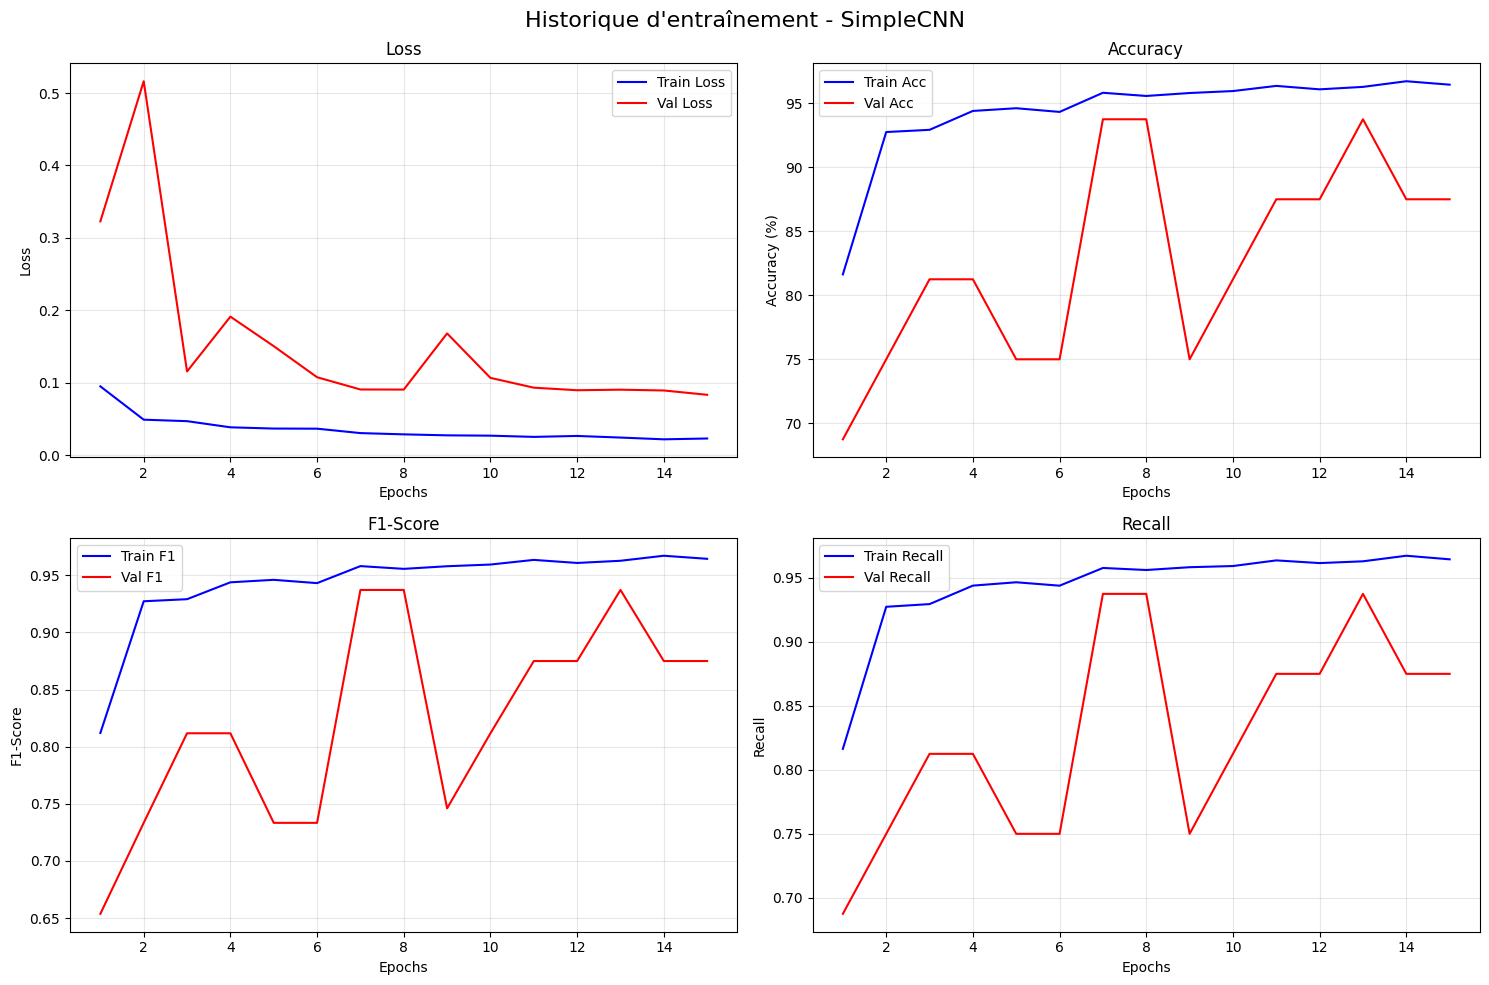


Évaluation du modèle SimpleCNN sur le test set

Test Loss: 0.3138
Test Accuracy: 87.18%
Test F1-Score: 0.8554
Test Recall: 0.8402

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.71      0.81       234
   PNEUMONIA       0.85      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



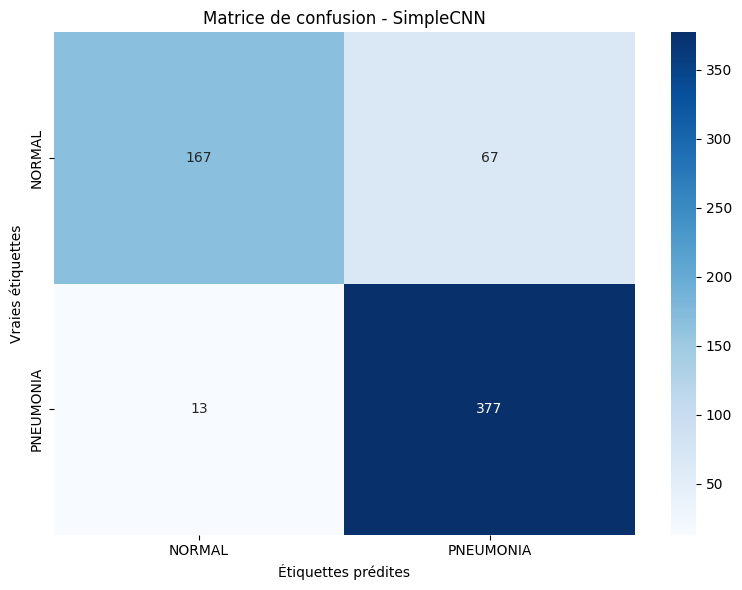


AUC-ROC: 0.9491


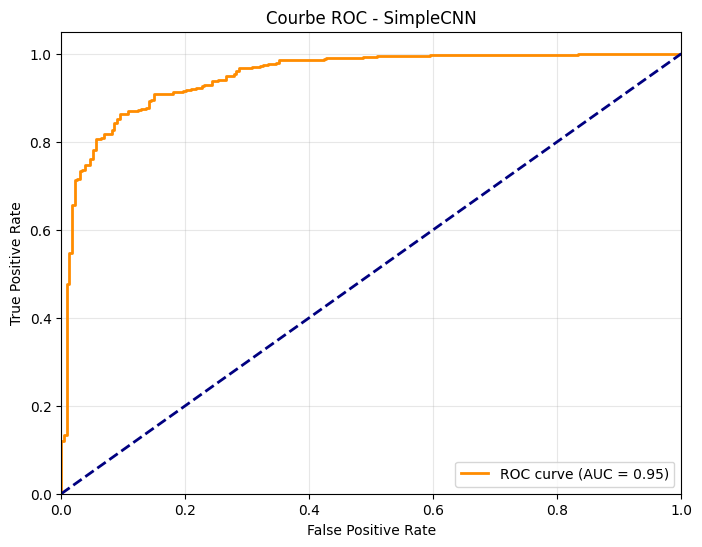


MODÈLE 2: HRNet (FINE-TUNING)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Utilisation de ResNet50 (fallback)

Entraînement du modèle: HRNet

Epoch 1/10
--------------------
Batch 0/163, Loss: 0.2284
Batch 20/163, Loss: 0.0115
Batch 40/163, Loss: 0.0289
Batch 60/163, Loss: 0.0410
Batch 80/163, Loss: 0.0060
Batch 100/163, Loss: 0.1982
Batch 120/163, Loss: 0.1037
Batch 140/163, Loss: 0.0105
Batch 160/163, Loss: 0.0088
Train Loss: 0.0426, Train Acc: 94.13%
Val Loss: 0.0261, Val Acc: 93.75%
Train F1: 0.9413, Val F1: 0.9373
Train Recall: 0.9415, Val Recall: 0.9375
Modèle sauvegardé (Accuracy: 93.75%)

Epoch 2/10
--------------------
Batch 0/163, Loss: 0.0473
Batch 20/163, Loss: 0.0083
Batch 40/163, Loss: 0.0253
Batch 60/163, Loss: 0.0622
Batch 80/163, Loss: 0.0145
Batch 100/163, Loss: 0.0210
Batch 120/163, Loss: 0.0262
Batch 140/163, Loss: 0.0973
Batch 160/163, Loss: 0.0270
Train Loss: 0.0220, Train Acc: 96.80%
Val Loss: 0.0519, Val Acc: 100.00%
Train F1: 0.9679, Val F1: 1.0000
Train Recall: 0.9676, Val Recall: 1.0000
Modèle sauvegardé (Accuracy: 100.00%)

Epoch 3

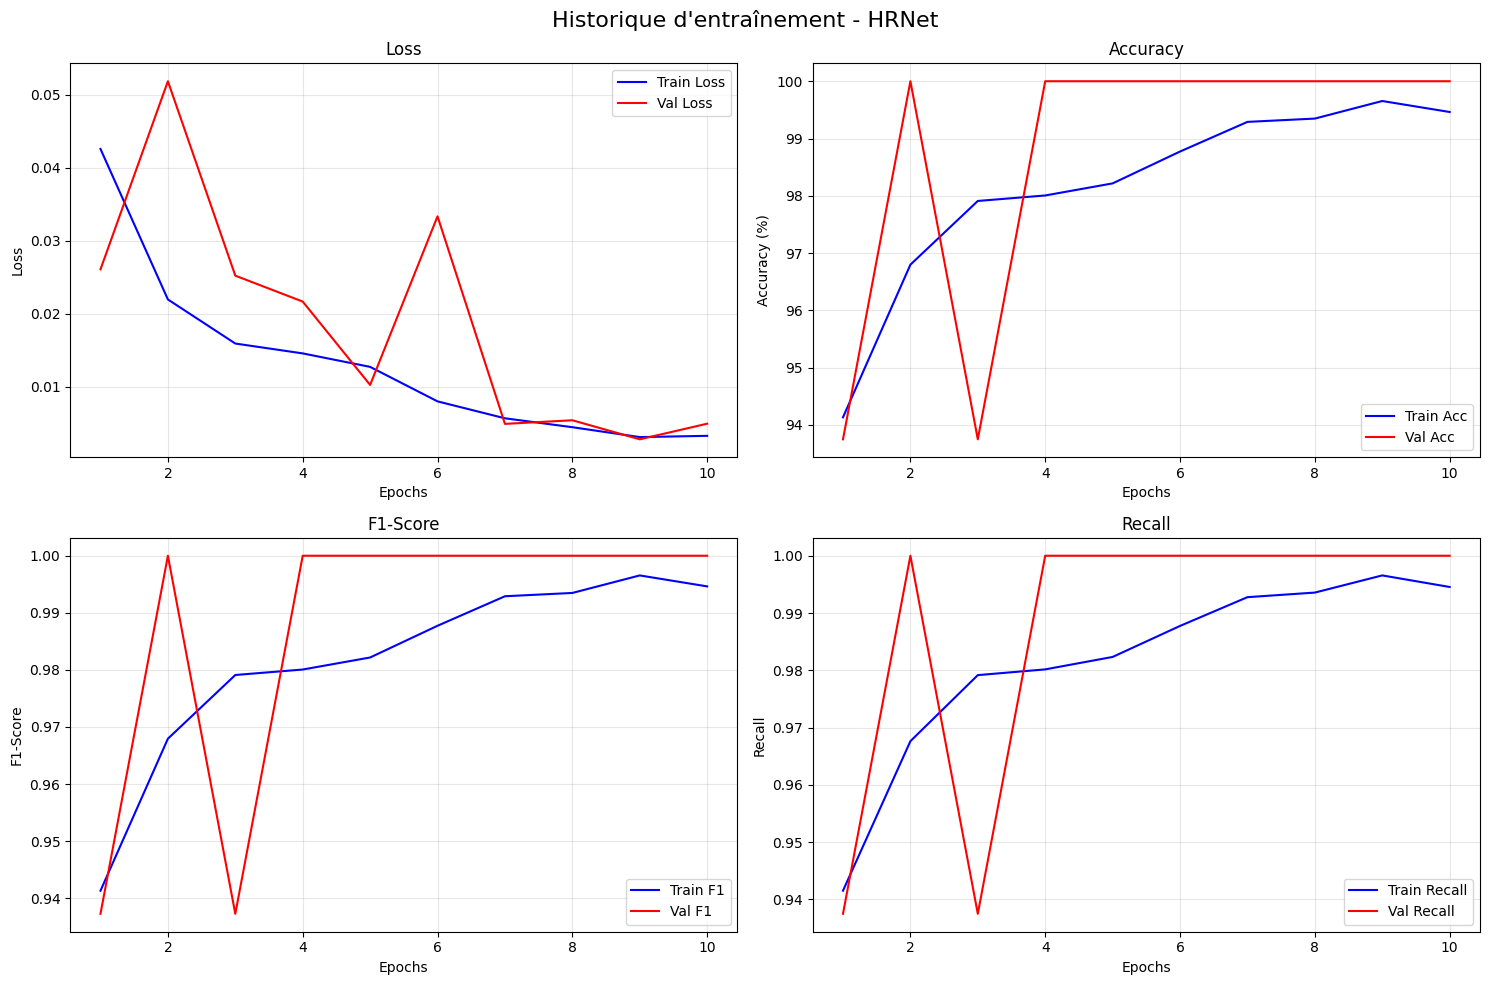


Évaluation du modèle HRNet sur le test set

Test Loss: 0.2538
Test Accuracy: 89.90%
Test F1-Score: 0.8860
Test Recall: 0.8688

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.75      0.85       234
   PNEUMONIA       0.87      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



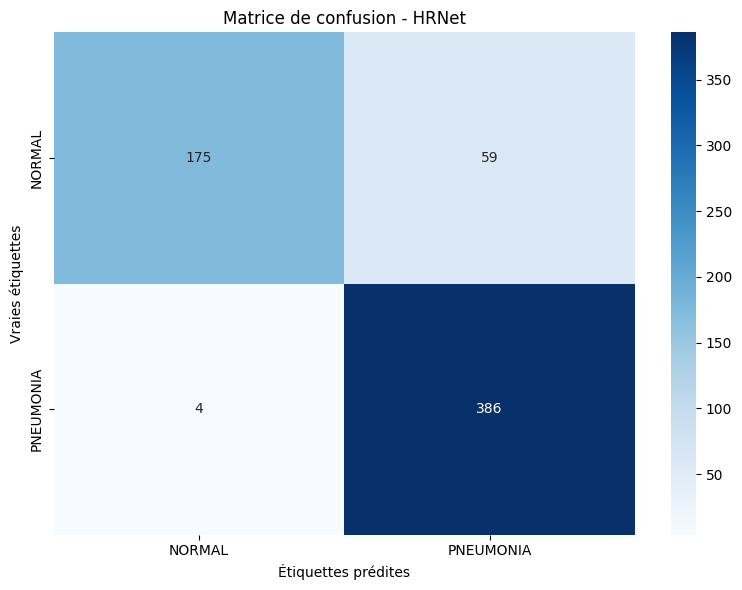


AUC-ROC: 0.9800


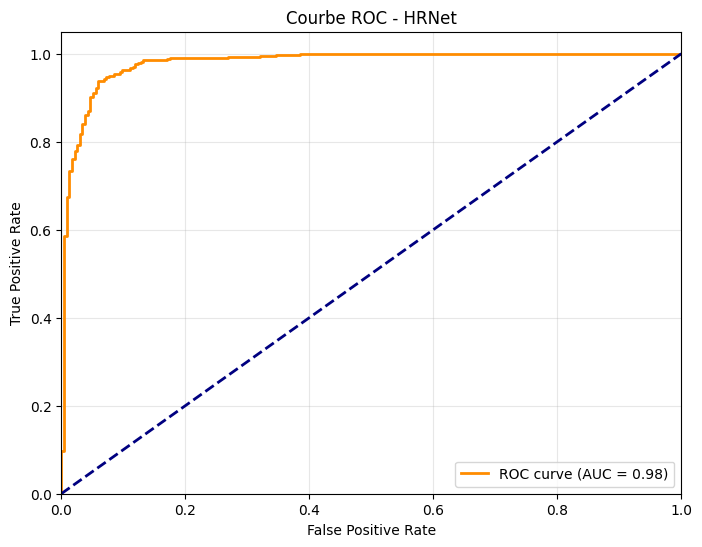


MODÈLE 3: VISION TRANSFORMER


2025-12-14 11:51:40.574253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765713100.747512      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765713100.793851      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle ViT chargé avec succès

Entraînement du modèle: ViT

Epoch 1/10
--------------------
Batch 0/163, Loss: 0.1992
Batch 20/163, Loss: 0.0451
Batch 40/163, Loss: 0.0635
Batch 60/163, Loss: 0.0421
Batch 80/163, Loss: 0.0061
Batch 100/163, Loss: 0.0219
Batch 120/163, Loss: 0.0073
Batch 140/163, Loss: 0.0720
Batch 160/163, Loss: 0.0122
Train Loss: 0.0478, Train Acc: 92.48%
Val Loss: 0.0831, Val Acc: 81.25%
Train F1: 0.9245, Val F1: 0.8057
Train Recall: 0.9241, Val Recall: 0.8125
Modèle sauvegardé (Accuracy: 81.25%)

Epoch 2/10
--------------------
Batch 0/163, Loss: 0.0521
Batch 20/163, Loss: 0.0732
Batch 40/163, Loss: 0.0509
Batch 60/163, Loss: 0.0084
Batch 80/163, Loss: 0.0127
Batch 100/163, Loss: 0.0150
Batch 120/163, Loss: 0.0358
Batch 140/163, Loss: 0.0311
Batch 160/163, Loss: 0.0142
Train Loss: 0.0307, Train Acc: 95.94%
Val Loss: 0.0349, Val Acc: 100.00%
Train F1: 0.9594, Val F1: 1.0000
Train Recall: 0.9597, Val Recall: 1.0000
Modèle sauvegardé (Accuracy: 100.00%)

Epoch 3/10
---

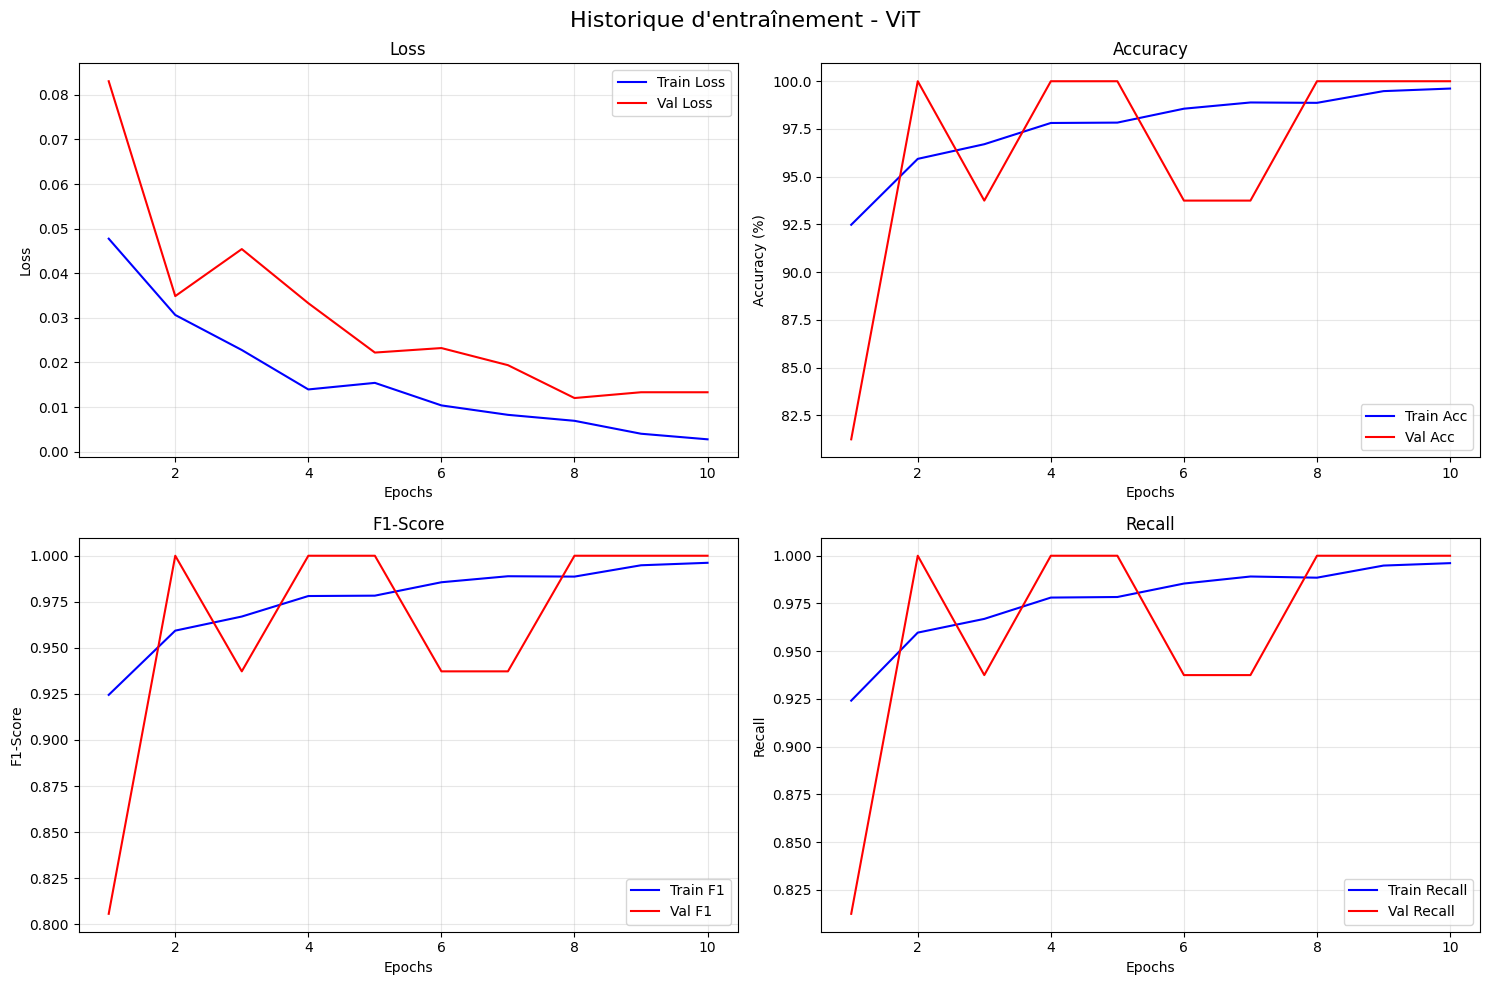


Évaluation du modèle ViT sur le test set

Test Loss: 0.2202
Test Accuracy: 91.51%
Test F1-Score: 0.9050
Test Recall: 0.8893

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.79      0.87       234
   PNEUMONIA       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



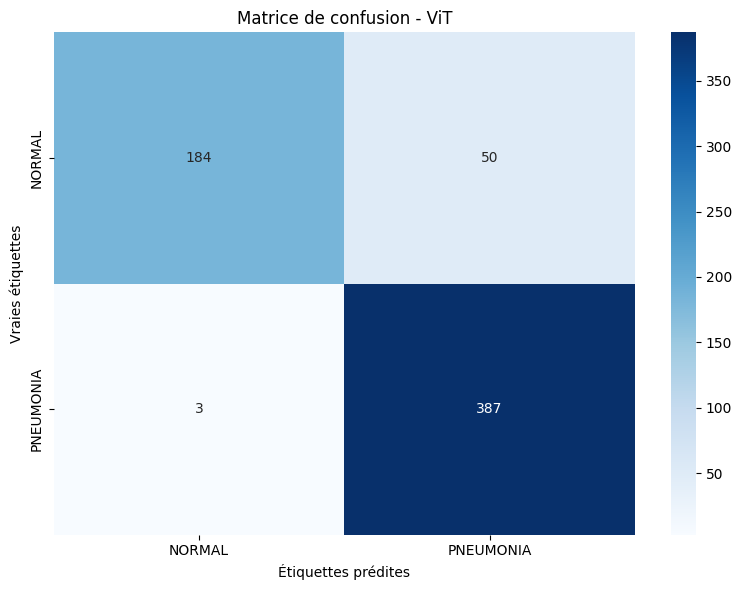


AUC-ROC: 0.9841


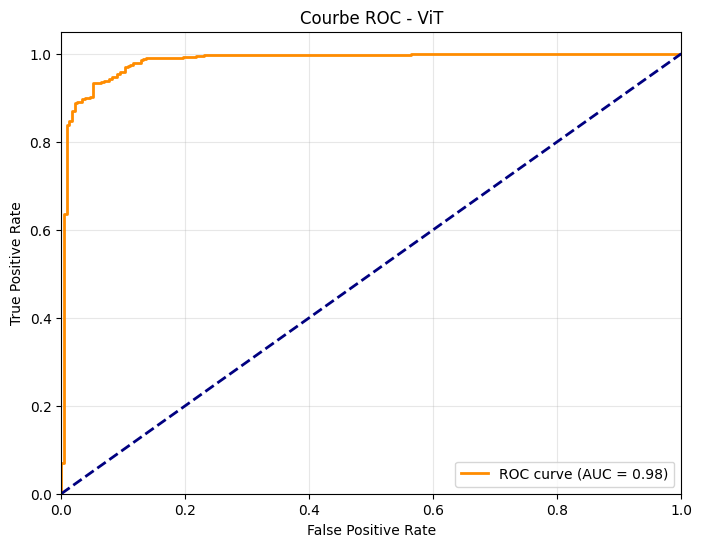

In [20]:
results = train_and_evaluate_models()

# 8. COMPARAISON DES MODÈLES

In [22]:
def compare_models(results):
    """Compare les performances des différents modèles"""
    
    print("\n" + "="*60)
    print("COMPARAISON DES MODÈLES")
    print("="*60)
    
    # Préparation des données pour la comparaison
    comparison_data = []
    
    for model_name, model_results in results.items():
        comparison_data.append({
            'Modèle': model_name,
            'Accuracy (%)': round(model_results['accuracy'], 2),
            'F1-Score': round(model_results['f1_score'], 4),
            'Recall': round(model_results['recall'], 4),
            'Loss': round(model_results['loss'], 4)
        })
    
    # Création d'un DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print("\nTableau comparatif:")
    print(comparison_df.to_string(index=False))
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    models = comparison_df['Modèle'].tolist()
    
    # Accuracy
    axes[0, 0].bar(models, comparison_df['Accuracy (%)'], color=['skyblue', 'salmon', 'lightgreen'])
    axes[0, 0].set_title('Accuracy par modèle')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # F1-Score
    axes[0, 1].bar(models, comparison_df['F1-Score'], color=['skyblue', 'salmon', 'lightgreen'])
    axes[0, 1].set_title('F1-Score par modèle')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Recall
    axes[1, 0].bar(models, comparison_df['Recall'], color=['skyblue', 'salmon', 'lightgreen'])
    axes[1, 0].set_title('Recall par modèle')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Loss
    axes[1, 1].bar(models, comparison_df['Loss'], color=['skyblue', 'salmon', 'lightgreen'])
    axes[1, 1].set_title('Loss par modèle')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Comparaison des performances des modèles', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Courbes ROC comparatives
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for model_name, model_results in results.items():
        if 'probabilities' in model_results and len(model_results['probabilities'][0]) == 2:
            probs = np.array(model_results['probabilities'])[:, 1]
            targets = model_results['targets']
            
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(targets, probs)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Courbes ROC comparatives')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df



COMPARAISON DES MODÈLES

Tableau comparatif:
   Modèle  Accuracy (%)  F1-Score  Recall   Loss
SimpleCNN         87.18    0.8554  0.8402 0.3138
    HRNet         89.90    0.8860  0.8688 0.2538
      ViT         91.51    0.9050  0.8893 0.2202


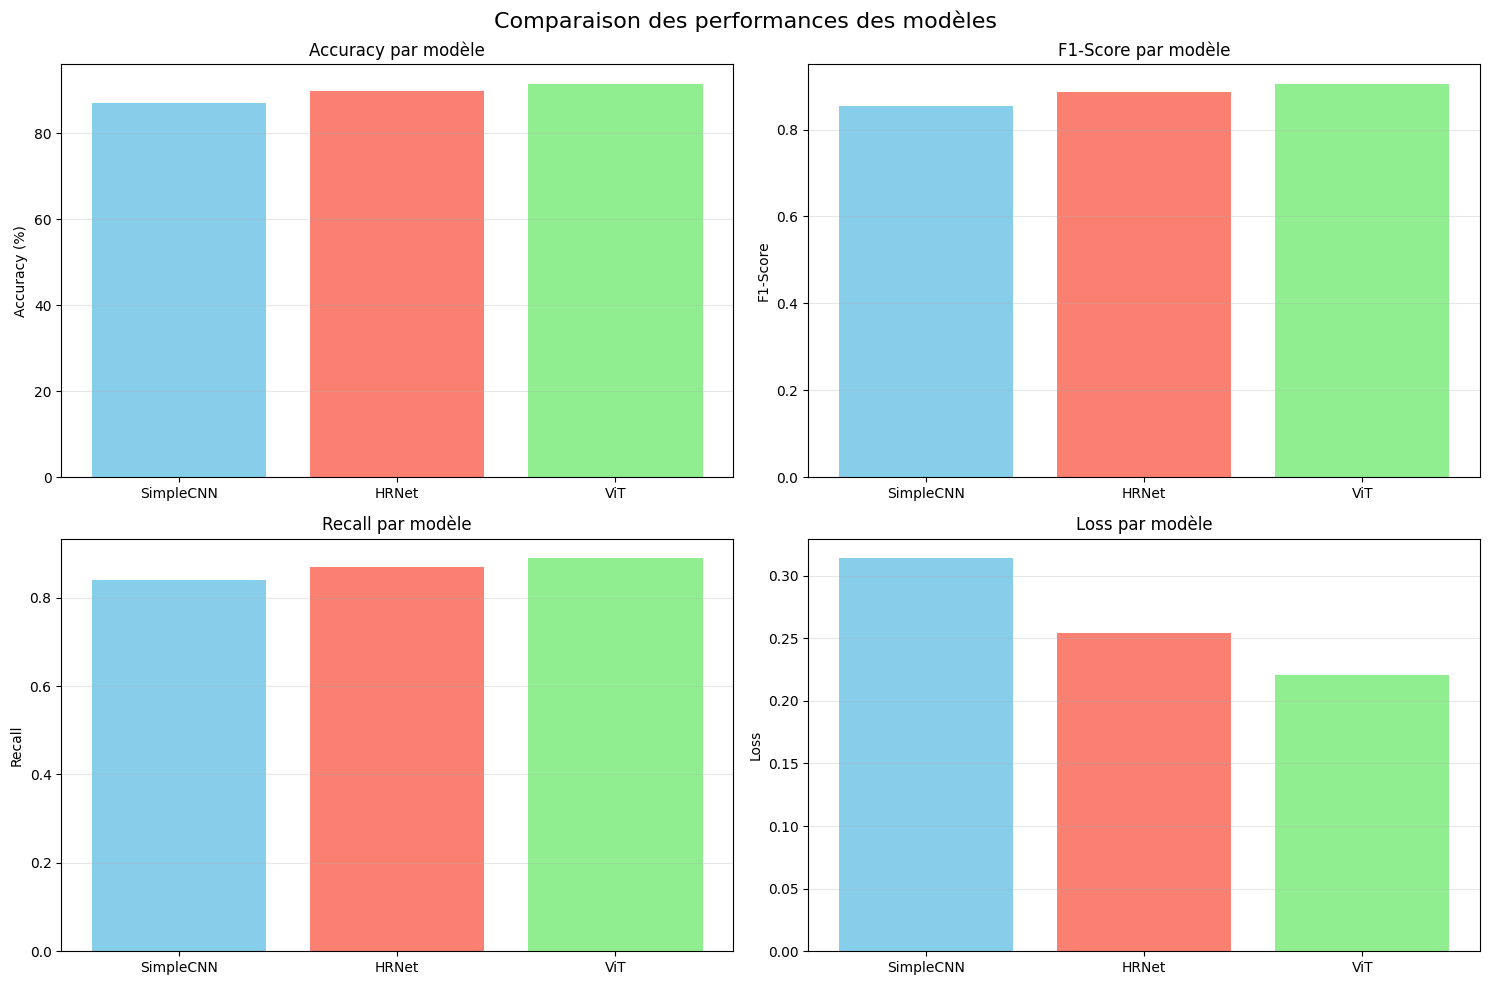

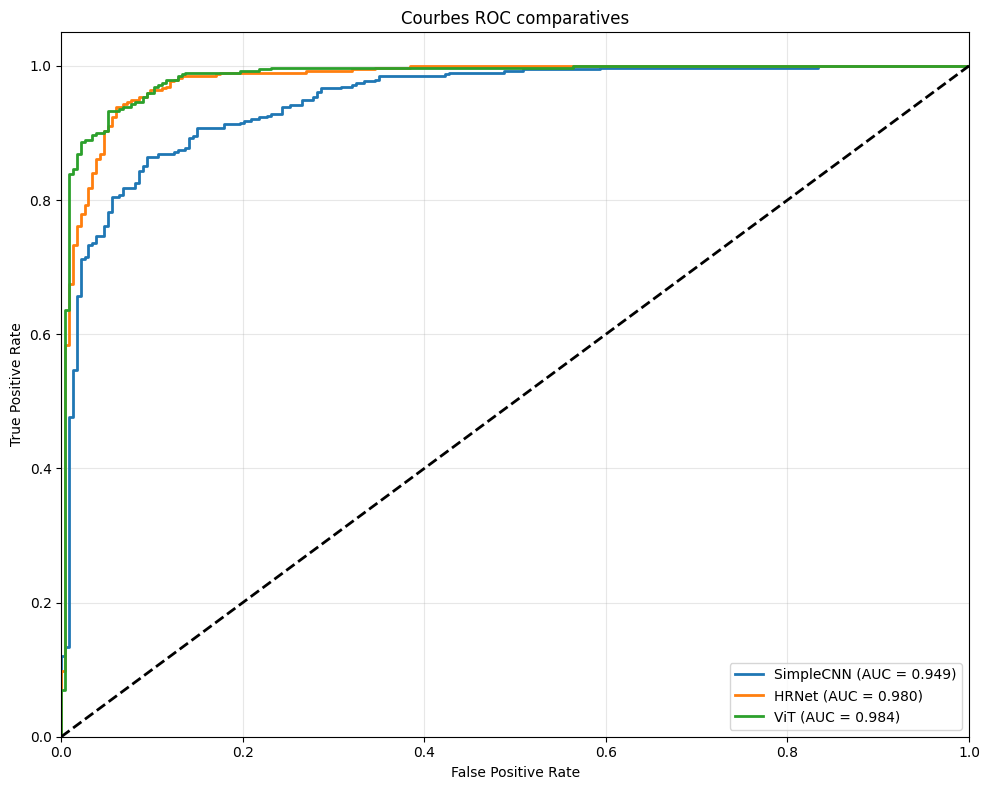

In [23]:
comparison_df = compare_models(results)

In [30]:
print("fin project")

fin project
